In [1]:
# for language processing
import nltk
from collections import Counter

# for fetching the corpus
from urllib.request import urlopen

# for data storage, manipulation, and display
import numpy as np
import pandas as pd

# for standard machine learning tools
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Introduction

This stylometry project uses computational tools to compare the writing styles of the authors Dorothy L. Sayers (1893-1957) and Agatha Christie (1890-1976). Specifically, it examines whether frequencies of types and parts of speech can be used to distinguish between the two authors' stylomes.

Sayers and Christie lived in the same country in the same time period and were roughly the same age. Moreover, they both wrote mystery novels and were even part of the same [Detection Club](https://www.theguardian.com/books/2020/feb/04/dorothy-l-sayers-and-the-detection-club). As a result of these similarities in place, time, and genre, the works of these two authors are ideal for comparison.

At the time of writing, only three of Sayers's detective novels are in the public domain. This analysis pairs each of these three novels by Sayers with a corresponding detective novel by Christie that was published in the same year. The Sayers novels feature the detective Lord Peter Wimsey, while the Christie novels feature the detective Hercule Poirot.

The full list of novels is as follows:

| Year | Dorothy L. Sayers | Agatha Christie |
| --- | :--- | :--- |
| 1923 | *Whose Body?* | *The Murder on the Links* |
| 1926 | *Unnatural Death* | *The Murder of Roger Ackroyd* |
| 1927 | *Clouds of Witness* | *The Big Four* |

Since each pair of novels was written in the same genre and published in the same year, major differences of style are likely due to the authors' individual stylomes rather than  confounding factors such as genre and time period. Thus, these six novels present a small but promising corpus for computationally comparing the styles of Sayers and Christie.

# Creating the Corpus

We begin by assembling our corpus of texts. We use `pandas` to store, access, and display information about the corpus.

First, we retrieve each text from Project Gutenberg and tokenize it using the `nltk`
library. We consider only alphabetic tokens for this analysis.

In [2]:
"""Retrieve a Project Gutenberg text given its ID."""
def get_gutenberg_text(
    pgid, start_phrase='CHAPTER I', stop_phrase = '*** END OF THE PROJECT GUTENBERG EBOOK'
):
    raw = urlopen(f'https://gutenberg.org/ebooks/{pgid}.txt.utf-8').read().decode()
    raw = raw.replace('—',' — ') # to prevent em-dash from being treated like a hyphen
    # remove Project Gutenberg header and footer
    start = raw.find(start_phrase)
    stop = raw.rfind(stop_phrase)
    assert(stop > start >= 0)
    return raw[start:stop]

"""Returns a case-folded list of alphabetic tokens from the given text."""
def tokenize(text):
    return [token.casefold() for token in nltk.word_tokenize(text) if token.isalpha()]

In [3]:
corpus = pd.DataFrame([
    { 'title': 'Whose Body?', 'author': 'Sayers', 'year': 1923,
     'pgid': '58820', 'start_phrase': 'CHAPTER I' },
    { 'title': 'Unnatural Death', 'author': 'Sayers', 'year': 1926,
     'pgid': '70008', 'start_phrase': 'CHAPTER I' },
    { 'title': 'Clouds of Witness', 'author': 'Sayers', 'year': 1927,
     'pgid': '70432', 'start_phrase': 'CHAPTER I' },
    { 'title': 'The Murder of the Links', 'author': 'Christie', 'year': 1923,
     'pgid': '58866', 'start_phrase': '1 A Fellow Traveller' },
    { 'title': 'The Murder of Roger Ackroyd', 'author': 'Christie', 'year': 1926,
     'pgid': '69087', 'start_phrase': 'CHAPTER I' },
    { 'title': 'The Big Four', 'author': 'Christie', 'pgid': '70114', 'year': 1927,
     'start_phrase': '1. THE UNEXPECTED GUEST' }
])

# fetch and tokenize texts
corpus['text'] = corpus.apply(
    lambda info: tokenize(get_gutenberg_text(info['pgid'], info['start_phrase'])),
    axis=1
)
# compute frequency distributions of tokens
corpus['freqdist'] = corpus['text'].apply(nltk.FreqDist)
# compute length of each text
corpus['length'] = corpus['text'].apply(len)
corpus

,title,author,year,pgid,start_phrase,text,freqdist,length
0,Whose Body?,Sayers,1923,58820,CHAPTER I,"[chapter, i, oh, damn, said, lord, peter, wims...","{'chapter': 13, 'i': 1599, 'oh': 93, 'damn': 4...",59302
1,Unnatural Death,Sayers,1926,70008,CHAPTER I,"[chapter, i, overheard, death, was, certainly,...","{'chapter': 24, 'i': 1889, 'overheard': 1, 'de...",80472
2,Clouds of Witness,Sayers,1927,70432,CHAPTER I,"[chapter, i, of, his, malice, aforethought, wh...","{'chapter': 19, 'i': 1819, 'of': 1989, 'his': ...",80974
3,The Murder of the Links,Christie,1923,58866,1 A Fellow Traveller,"[a, fellow, traveller, an, appeal, for, help, ...","{'a': 1393, 'fellow': 8, 'traveller': 3, 'an':...",63734
4,The Murder of Roger Ackroyd,Christie,1926,69087,CHAPTER I,"[chapter, i, sheppard, at, the, breakfast, tab...","{'chapter': 27, 'i': 2714, 'sheppard': 81, 'at...",70331
5,The Big Four,Christie,1927,70114,1. THE UNEXPECTED GUEST,"[the, unexpected, guest, the, man, from, the, ...","{'the': 2815, 'unexpected': 8, 'guest': 8, 'ma...",55110


For convenience, we will refer to each novel by an abbreviation consisting of the author's name concatenated with the last two digits of the publication year.

In [4]:
corpus['abbrev'] = corpus['author'].str.lower() + corpus['year'].astype('str').str.slice(2,)
corpus[['title', 'abbrev']]

,title,abbrev
0,Whose Body?,sayers23
1,Unnatural Death,sayers26
2,Clouds of Witness,sayers27
3,The Murder of the Links,christie23
4,The Murder of Roger Ackroyd,christie26
5,The Big Four,christie27


These six novels are roughly comparable in length, ranging from 55110 to 80974 tokens long.

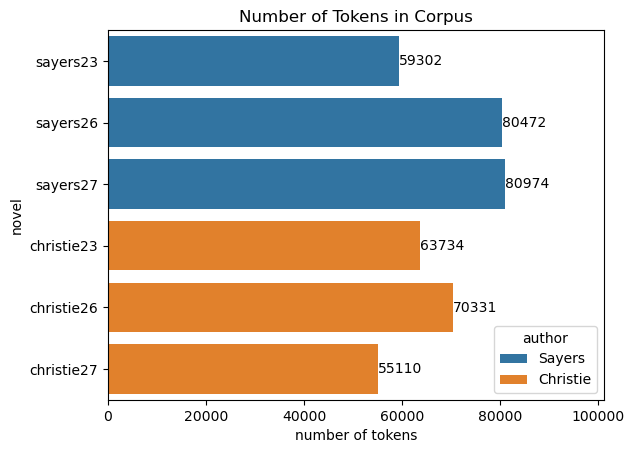

In [5]:
ax = sns.barplot(
    data = corpus,
    x = 'length',
    y = 'abbrev',
    hue = 'author',
)
for container in ax.containers:
    ax.bar_label(container)
ax.set_xlim(0, max(corpus['length'])*1.25)
ax.set_xlabel('number of tokens')
ax.set_ylabel('novel')
ax.set_title('Number of Tokens in Corpus');

To gain insight into the stylomes revealed in these six novels, we will pursue two avenues of exploration: analysis of type frequency, and analysis of part-of-speech frequency.

# Stylometry with Type Frequency

Firstly, we will compare the frequency of types in the two authors' texts to glean information about their writing styles.

We begin by finding the frequencies of the 15 types that occur most frequently across the entire corpus.

In [6]:
# find the fifteen most common types across the entire corpus
corpuswide_most_freq = pd.DataFrame(
    nltk.FreqDist(np.concatenate(corpus['text'].to_numpy())).most_common(15),
    columns=['type', 'frequency']
)
stopwords = set(nltk.corpus.stopwords.words('english'))
corpuswide_most_freq['stopword'] = corpuswide_most_freq['type'].apply(
    lambda x: 'stopword' if x in stopwords else 'not a stopword'
)

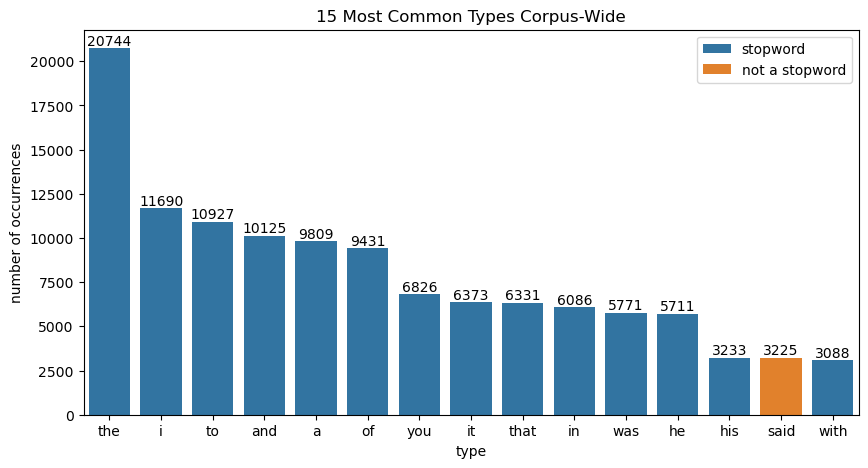

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(
    data = corpuswide_most_freq,
    x = 'type',
    y = 'frequency',
    hue = 'stopword',
    ax = ax
)
for container in ax.containers:
    ax.bar_label(container)
ax.set_ylabel('number of occurrences')
ax.set_title('15 Most Common Types Corpus-Wide')
ax.legend();

As the graph above shows, the 15 most common types follow a pattern somewhat similar to Zipf's Law. Unsurprisingly, all but one of these types is included in `nltk`'s set of English stopwords. The single exception is the word "said", a verb one would expect to find frequently in novels as a dialogue marker.

Now that we have the 15 most common types, we can find out how often each of them occurs in each novel in our corpus. Since the novels vary in length, we will normalize the frequency counts from each novel by dividing them by the number of tokens in that novel. We can then examine the resulting frequency rates to see if they reveal significant differences in Sayers's and Christie's writing styles.

In [8]:
# frequency rates for each novel for each of the 15 most common types
freqs = pd.DataFrame(
    index=corpus['abbrev'].values,
    columns=corpuswide_most_freq['type'].values, 
    data = [
        [
            corpus.loc[i,'freqdist'][w]/corpus.loc[i,'length']
            for w in corpuswide_most_freq['type'].values
        ] 
        for i in corpus.index
    ])
freqs['author'] = freqs.index.str.slice(0,-2).str.title()
freqs

,the,i,to,and,a,of,you,it,that,in,was,he,his,said,with,author
sayers23,0.050437,0.026964,0.026458,0.026694,0.025429,0.024080,0.018043,0.015328,0.012731,0.016070,0.010556,0.014856,0.007757,0.009595,0.007470,Sayers
sayers26,0.049210,0.023474,0.027898,0.027873,0.025127,0.023138,0.015595,0.015608,0.015807,0.014726,0.014576,0.007468,0.004424,0.007058,0.007928,Sayers
sayers27,0.053499,0.022464,0.025292,0.027206,0.024353,0.024563,0.014931,0.015499,0.013548,0.015400,0.013165,0.015770,0.010250,0.009373,0.007509,Sayers
christie23,0.052609,0.030753,0.026862,0.021762,0.021856,0.021652,0.017463,0.015627,0.017589,0.014309,0.015408,0.014341,0.009524,0.004472,0.007641,Christie
christie26,0.046821,0.038589,0.027299,0.019095,0.021939,0.020460,0.018271,0.015839,0.017716,0.013067,0.014617,0.016053,0.006953,0.011403,0.006882,Christie
christie27,0.051080,0.031011,0.026003,0.024787,0.024878,0.024188,0.016222,0.015297,0.015242,0.015787,0.016258,0.016494,0.008909,0.004391,0.007766,Christie


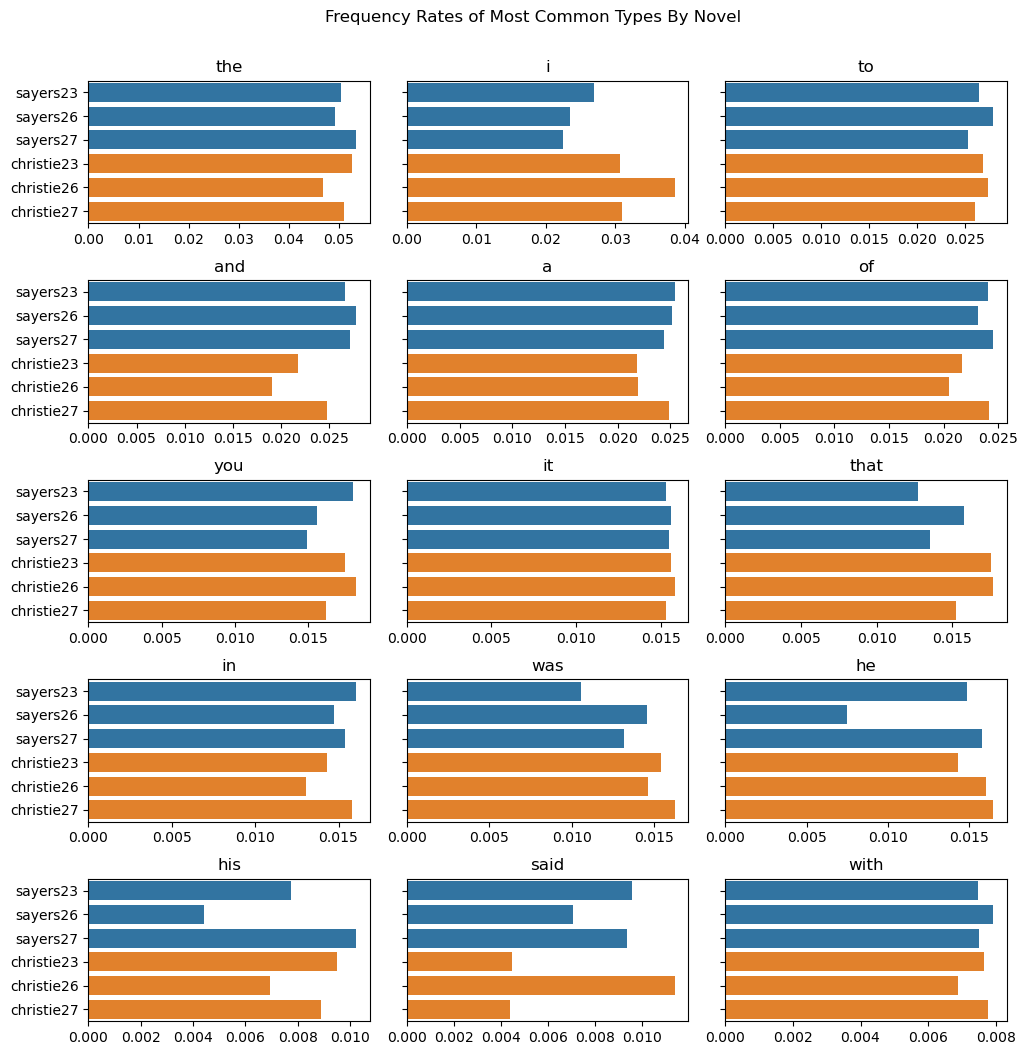

In [9]:
nrows = 5
ncols = 3
types = freqs.columns[:-1].to_numpy().reshape((nrows,ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey = True, figsize=(10,10))
fig.tight_layout(h_pad=2)
for row in range(nrows):
    for col in range(ncols):
        ax = axes[row][col]
        t = types[row][col]
        ax.set_title(t)
        sns.barplot(
            data = freqs[[t, 'author']].reset_index(),
            x = t,
            y = 'index',
            hue = 'author',
            legend = False,
            ax = ax
        )
        ax.set_ylabel('')
        ax.set_xlabel('')
fig.suptitle('Frequency Rates of Most Common Types By Novel', y = 1.05);

Examining the table and the accompanying barplots, we can see some notable differences in frequency rates of types between the novels written by Sayers and the novels written by Christie. These differences become clearer if we compare overall frequency rates between Sayers's novels taken as a whole and Christie's novels taken as a whole.

In [10]:
sayers_texts = np.concatenate(corpus[corpus['author'] == 'Sayers']['text'].to_numpy())
sayers_len = len(sayers_texts)
sayers_freqdist = nltk.FreqDist(sayers_texts)

christie_texts = np.concatenate(corpus[corpus['author'] == 'Christie']['text'].to_numpy())
christie_len = len(christie_texts)
christie_freqdist = nltk.FreqDist(christie_texts)

freqs_total = pd.DataFrame(
    index=['Sayers', 'Christie'],
    columns=corpuswide_most_freq['type'].values, 
    data = [
        [ freqdist[w]/length for w in corpuswide_most_freq['type'].values ] 
        for freqdist, length in zip(
            [sayers_freqdist, christie_freqdist],
            [sayers_len, christie_len]
        )
    ])
freqs_total

,the,i,to,and,a,of,you,it,that,in,was,he,his,said,with
Sayers,0.051113,0.024041,0.026555,0.027312,0.024924,0.023914,0.016009,0.015493,0.014152,0.015334,0.012979,0.012498,0.007456,0.008589,0.007651
Christie,0.050012,0.033741,0.026774,0.021652,0.022767,0.021948,0.017402,0.015610,0.016953,0.014278,0.015361,0.015605,0.008389,0.007025,0.007395


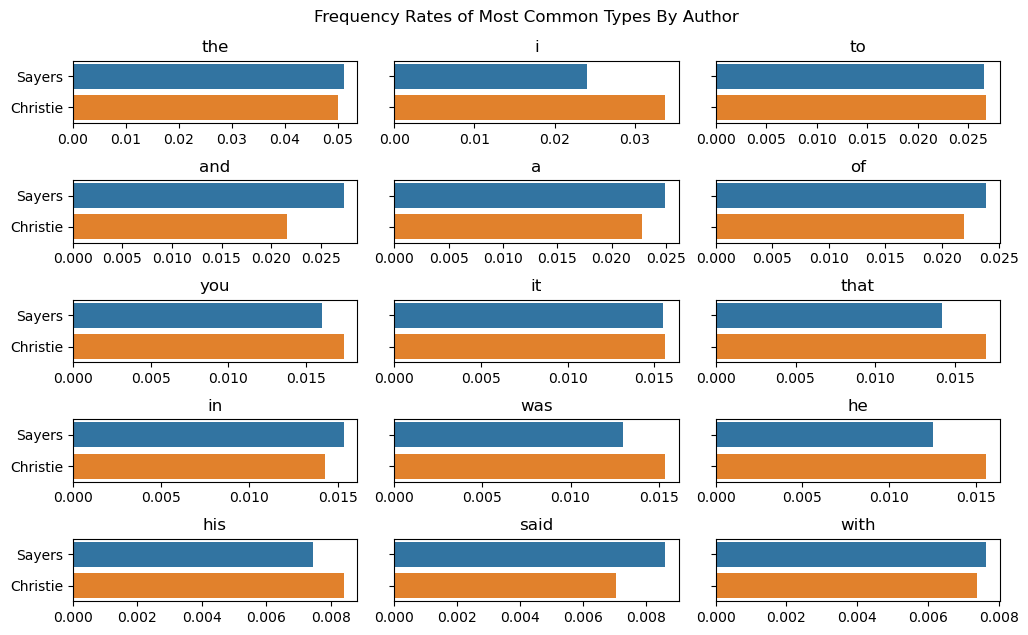

In [11]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey = True, figsize=(10,6))
fig.tight_layout(h_pad=2)
for row in range(nrows):
    for col in range(ncols):
        ax = axes[row][col]
        t = types[row][col]
        ax.set_title(t)
        sns.barplot(
            data = freqs_total[t].reset_index(),
            x = t,
            y = 'index',
            hue = 'index',
            legend = False,
            ax = ax
        )
        ax.set_ylabel('')
        ax.set_xlabel('')
fig.suptitle('Frequency Rates of Most Common Types By Author', y = 1.05);

By looking at the tables and graphs above, we can see, for example, that Sayers consistently uses the conjunction "and" more often than Christie does. Meanwhile, the pronouns "I" and "you" occur more frequently in Christie's novels than in Sayers's.

These differences in rates suggest that we can use the type counts themselves to distinguish between authors. To see if this is indeed the case, we can vectorize the corpus using `sklearn`'s `CountVectorizer`, which uses the 100 most common word types as features.

In [12]:
joined_corpus = corpus['text'].str.join(' ')

vec = CountVectorizer(input='content', max_features=100)
X = vec.fit_transform(joined_corpus).toarray()
vec.get_feature_names_out()

array(['about', 'all', 'an', 'and', 'any', 'are', 'as', 'at', 'be',
       'been', 'but', 'by', 'can', 'come', 'could', 'did', 'do', 'don',
       'down', 'for', 'from', 'go', 'good', 'had', 'has', 'have', 'he',
       'her', 'here', 'him', 'his', 'if', 'in', 'into', 'is', 'it',
       'just', 'know', 'like', 'little', 'lord', 'man', 'me', 'might',
       'miss', 'more', 'must', 'my', 'no', 'not', 'now', 'of', 'old',
       'on', 'one', 'only', 'or', 'out', 'over', 'parker', 'peter',
       'poirot', 'quite', 'said', 'say', 'see', 'she', 'should', 'sir',
       'so', 'some', 'that', 'the', 'them', 'then', 'there', 'they',
       'think', 'this', 'time', 'to', 'two', 'up', 'us', 'very', 'was',
       'way', 'we', 'well', 'were', 'what', 'when', 'which', 'who',
       'will', 'with', 'would', 'yes', 'you', 'your'], dtype=object)

Notice that some of these features — the types `lord`, `peter`, `parker`, and `poirot` — are actually proper nouns referring to the main characters in the novels (Lord Peter Wimsey and Charles Parker from Sayers's novels, and Hercule Poirot from Christie's novels, respectively). These types will likely play a major role in distinguishing the two authors' works based on type counts.

Each of the six vectors in `X` represents the type counts for the corresponding novel. For example, the vector for *Whose Body?* looks like this:

In [13]:
X[0]

array([ 204,  265,  213, 1583,  124,  148,  350,  373,  302,  185,  360,
        222,  151,   90,   92,  104,  178,  142,  104,  368,  146,   85,
         97,  364,   75,  298,  881,  107,   95,  289,  460,  255,  953,
        127,  321,  909,  103,  183,  134,  135,  377,  238,  268,   84,
         12,   63,   46,  402,  241,  285,   90, 1428,  114,  425,  156,
         84,  203,  178,   90,  204,  336,    0,   72,  569,  137,  118,
        181,   85,  178,  226,   91,  755, 2991,  106,   95,  251,  157,
        116,  240,   99, 1569,   77,  213,   34,  185,  626,   77,  161,
        174,  143,  211,  134,  118,  134,   98,  443,  122,  183, 1070,
        202])

To visualize these vectors, we can use Principal Component Analysis (PCA) to project them into 2 dimensions instead of 100.

In [14]:
projected = pd.DataFrame(
    data = PCA(n_components=2).fit_transform(X),
    columns = ['x', 'y']
)
projected['label'] = corpus['abbrev']
projected['author'] = corpus['author']
projected

,x,y,label,author
0,-626.474853,739.514199,sayers23,Sayers
1,1249.931235,-419.537011,sayers26,Sayers
2,1206.562296,570.921994,sayers27,Sayers
3,-459.785091,-476.250945,christie23,Christie
4,-201.275210,-418.373613,christie26,Christie
5,-1168.958377,3.725376,christie27,Christie


Even with only 2 dimensions, these vectors allow us to distinguish between novels by Sayers and novels by Christie. In fact, the vectors for the two authors are linearly separable, as we can see by fitting a linear support vector classifier (SVC) to these vectors and then plotting the resultant decision boundary and margins.

In [15]:
"""Plot SVC decision boundary for the given data on the given axis.
Modified from Eric Leschinski's answer at https://stackoverflow.com/a/47582620
(CC BY-SA 3.0 license)."""
def plot_svc(X, y, axis):
    # create model
    model = SVC(kernel='linear')
    model.fit(X, y);
    # get axis limits
    xlim = axis.get_xlim()
    ylim = axis.get_ylim()
    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)
    # plot decision boundary and margins
    return axis.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.3,
               linestyles=['--', '-', '--'])

"""Plot projected vectors together with an SVC decision boundary and margins."""
def plot_projections(data, title, legend_loc):
    ax = sns.scatterplot(
        data = data,
        x = 'x',
        y = 'y',
        hue = 'author',
        style = 'author'
    )
    ax.set_title(title)
    for i in data.index:
        ax.annotate(
            text = data.loc[i, 'label'],
            xy = (data.loc[i, 'x'], data.loc[i, 'y']),
            textcoords = 'offset points',
            xytext = (4,-2.5),
        )
    ax.set_xlim(ax.get_xlim()[0], max(data['x']*1.4))

    contours = plot_svc(data[['x', 'y']].to_numpy(), data['author'], ax)

    svchandles, svclabels = contours.legend_elements()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles + svchandles[:2],
        labels + ['SVC decision boundary', 'SVC margin'],
        loc = legend_loc
    );

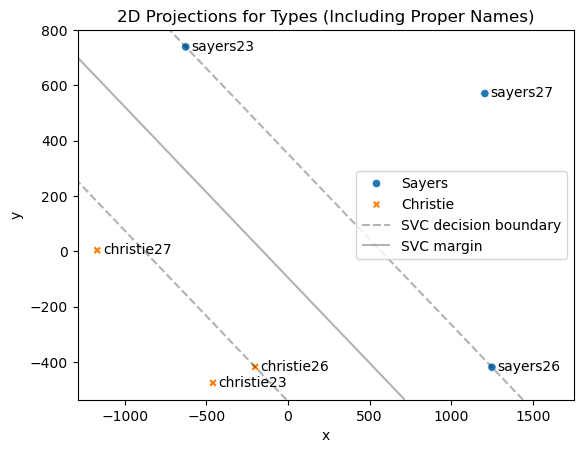

In [16]:
plot_projections(
    data = projected,
    title = '2D Projections for Types (Including Proper Names)',
    legend_loc = 'center right'
)

Interestingly, the vectors representing Christie's novels are clustered together more closely than the vectors representing Sayers's novels. This raises the question of whether Sayers's style fluctuates more than Christie's in her early novels, at least in terms of type counts. But it also serves as a warning to interpret the data with caution, especially given the small sample size.

As noted above, the fact that the type counts include  proper nouns referring to characters from the novels makes the classification task much easier. However, the inclusion of these types is a distraction from our main goal of analyzing the authors' stylomes. Protagonist names serve as a convenient way to tell which author wrote which novel, but they do not give us much information about the authors' writing styles. In fact, including protagonist names in our type counts may lead us to overlook the significance of other types that may be more salient for distinguishing stylomes.

This raises the question of whether or not the novels are still linearly separable if we consider only the most common 100 types that are not proper nouns. We can find this out by removing the offending proper nouns from the corpus and then redoing our analysis.

In [17]:
remove = ['lord peter', 'peter', 'parker', 'poirot']
for r in remove:
    joined_corpus = joined_corpus.str.replace(r, '')

Here are the 100 most common types in the corpus once the names of the main characters have been excluded:

In [18]:
vec = CountVectorizer(input='content', max_features=100)
X = vec.fit_transform(joined_corpus).toarray()
vec.get_feature_names_out()

array(['about', 'after', 'all', 'an', 'and', 'any', 'are', 'as', 'at',
       'be', 'been', 'but', 'by', 'can', 'come', 'could', 'did', 'do',
       'don', 'down', 'for', 'from', 'go', 'good', 'got', 'had', 'has',
       'have', 'he', 'her', 'here', 'him', 'his', 'how', 'if', 'in',
       'into', 'is', 'it', 'just', 'know', 'like', 'little', 'man', 'me',
       'might', 'miss', 'more', 'must', 'my', 'never', 'no', 'not', 'now',
       'of', 'old', 'on', 'one', 'only', 'or', 'out', 'over', 'quite',
       'said', 'say', 'see', 'she', 'should', 'sir', 'so', 'some', 'that',
       'the', 'them', 'then', 'there', 'they', 'think', 'this', 'time',
       'to', 'two', 'up', 'us', 'very', 'was', 'way', 'we', 'well',
       'were', 'what', 'when', 'which', 'who', 'will', 'with', 'would',
       'yes', 'you', 'your'], dtype=object)

And here are the resultant vectors, projected down into 2 dimensions using PCA.

In [19]:
projected = pd.DataFrame(
    data = PCA(n_components=2).fit_transform(X),
    columns = ['x', 'y']
)
projected['label'] = corpus['abbrev']
projected['author'] = corpus['author']
projected

,x,y,label,author
0,-763.793070,354.576434,sayers23,Sayers
1,1231.596941,-555.646307,sayers26,Sayers
2,1132.426047,736.767098,sayers27,Sayers
3,-366.675873,-322.098871,christie23,Christie
4,-126.073004,-238.270872,christie26,Christie
5,-1107.481041,24.672518,christie27,Christie


When we fit a linear SVC to these two-dimensional vectors, we discover that the margins have shrunk considerably. In other words, the differences between authors are less clear-cut now that we're excluding the character names from the analysis. However, the novels by the two authors are still linearly separable. This confirms that the relative frequencies of types in these six novels reflect the differences in the authors' writing styles.

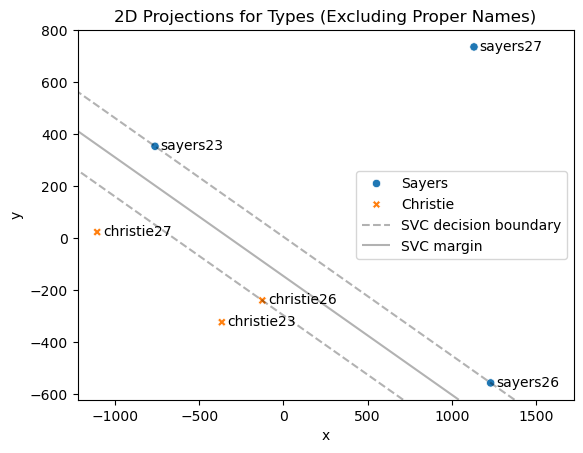

In [20]:
plot_projections(
    data = projected,
    title = '2D Projections for Types (Excluding Proper Names)',
    legend_loc = 'center right'
)

# Stylometry with Part-of-Speech Frequency

Secondly, we will compare the frequency rates of parts of speech in the two authors' texts to see if these also reflect differences in their writing styles.

We begin by tagging the tokenized texts of the novels with part-of-speech labels and then counting the number of occurrences of each tag. We use the universal tagset from `nltk`, which is defined as follows in the [NLTK book](https://www.nltk.org/book/ch05.html) written by Steven Bird, Ewan Klein, and Edward Loper (published under a CC BY-NC-ND 3.0 license):

| Tag | Meaning | English Examples |
| --- | ---| --- |
| ADJ  | adjective  | new, good, high, special, big, local |
| ADP  | adposition  | on, of, at, with, by, into, under |
| ADV  | adverb  | really, already, still, early, now |
| CONJ  | conjunction  | and, or, but, if, while, although |
| DET  | determiner, article  | the, a, some, most, every, no, which |
| NOUN  | noun  | year, home, costs, time, Africa |
| NUM  | numeral  | twenty-four, fourth, 1991, 14:24 |
| PRT  | particle  | at, on, out, over per, that, up, with |
| PRON  | pronoun  | he, their, her, its, my, I, us |
| VERB  | verb  | is, say, told, given, playing, would |
| .  | punctuation marks  | . , ; ! |
| X  | other  | ersatz, esprit, dunno, gr8, univeristy |

In [21]:
# universal tagset
tagset = [
    'VERB', 'NOUN', 'PRON', 'ADJ', 'ADV', 'ADP', 'CONJ', 'DET', 'NUM', 'PRT', 'X', '.'
]
corpus['tagged'] = corpus['text'].apply(lambda text: nltk.pos_tag(text, tagset='universal'))
corpus['tags'] = corpus['tagged'].apply(lambda text: [tag for token, tag in text])
corpus['tag_freq'] = corpus['tags'].apply(Counter)

Our corpus now includes part-of-speech tag information and looks like this:

In [22]:
corpus

,title,author,year,pgid,start_phrase,text,freqdist,length,abbrev,tagged,tags,tag_freq
0,Whose Body?,Sayers,1923,58820,CHAPTER I,"[chapter, i, oh, damn, said, lord, peter, wims...","{'chapter': 13, 'i': 1599, 'oh': 93, 'damn': 4...",59302,sayers23,"[(chapter, NOUN), (i, NOUN), (oh, VERB), (damn...","[NOUN, NOUN, VERB, NOUN, VERB, ADJ, NOUN, NOUN...","{'NOUN': 13537, 'VERB': 12937, 'ADJ': 5095, 'A..."
1,Unnatural Death,Sayers,1926,70008,CHAPTER I,"[chapter, i, overheard, death, was, certainly,...","{'chapter': 24, 'i': 1889, 'overheard': 1, 'de...",80472,sayers26,"[(chapter, NOUN), (i, NOUN), (overheard, VERB)...","[NOUN, NOUN, VERB, NOUN, VERB, ADV, ADJ, ADJ, ...","{'NOUN': 17306, 'VERB': 18077, 'ADV': 5883, 'A..."
2,Clouds of Witness,Sayers,1927,70432,CHAPTER I,"[chapter, i, of, his, malice, aforethought, wh...","{'chapter': 19, 'i': 1819, 'of': 1989, 'his': ...",80974,sayers27,"[(chapter, NOUN), (i, NOUN), (of, ADP), (his, ...","[NOUN, NOUN, ADP, PRON, NOUN, NOUN, PRON, VERB...","{'NOUN': 18220, 'ADP': 9665, 'PRON': 8241, 'VE..."
3,The Murder of the Links,Christie,1923,58866,1 A Fellow Traveller,"[a, fellow, traveller, an, appeal, for, help, ...","{'a': 1393, 'fellow': 8, 'traveller': 3, 'an':...",63734,christie23,"[(a, DET), (fellow, ADJ), (traveller, NOUN), (...","[DET, ADJ, NOUN, DET, NOUN, ADP, NOUN, ADP, DE...","{'DET': 6903, 'ADJ': 4401, 'NOUN': 13403, 'ADP..."
4,The Murder of Roger Ackroyd,Christie,1926,69087,CHAPTER I,"[chapter, i, sheppard, at, the, breakfast, tab...","{'chapter': 27, 'i': 2714, 'sheppard': 81, 'at...",70331,christie26,"[(chapter, NOUN), (i, NOUN), (sheppard, VERB),...","[NOUN, NOUN, VERB, ADP, DET, NOUN, ADJ, NOUN, ...","{'NOUN': 14851, 'VERB': 16880, 'ADP': 7718, 'D..."
5,The Big Four,Christie,1927,70114,1. THE UNEXPECTED GUEST,"[the, unexpected, guest, the, man, from, the, ...","{'the': 2815, 'unexpected': 8, 'guest': 8, 'ma...",55110,christie27,"[(the, DET), (unexpected, ADJ), (guest, NOUN),...","[DET, ADJ, NOUN, DET, NOUN, ADP, DET, NOUN, PR...","{'DET': 6086, 'ADJ': 4121, 'NOUN': 11539, 'ADP..."


For each part-of-speech tag, we can calculate how often it occurs in each novel in our corpus. Once again, we use the frequency rates rather than the counts, normalizing the frequencies by dividing by novel length.

In [23]:
tag_freqs = pd.DataFrame(
    index=corpus['abbrev'].values,
    columns=tagset, 
    data = [
        [corpus.loc[i,'tag_freq'][t]/corpus.loc[i,'length'] for t in tagset] 
        for i in corpus.index
    ])
tag_freqs['author'] = freqs.index.str.slice(0,-2).str.title()
tag_freqs

,VERB,NOUN,PRON,ADJ,ADV,ADP,CONJ,DET,NUM,PRT,X,.,author
sayers23,0.218155,0.228272,0.098563,0.085916,0.067232,0.116269,0.036694,0.109136,0.005093,0.033591,0.001079,0.000000,Sayers
sayers26,0.224637,0.215056,0.097525,0.085819,0.073106,0.114375,0.038461,0.110312,0.005343,0.034409,0.000944,0.000012,Sayers
sayers27,0.218737,0.225010,0.101773,0.076963,0.073196,0.119359,0.036172,0.109529,0.005273,0.032554,0.001420,0.000012,Sayers
christie23,0.234679,0.210296,0.118869,0.069053,0.074356,0.111432,0.034063,0.108310,0.006260,0.032039,0.000643,0.000000,Christie
christie26,0.240008,0.211159,0.111587,0.077647,0.078770,0.109738,0.028409,0.101492,0.007209,0.033413,0.000569,0.000000,Christie
christie27,0.225386,0.209381,0.114335,0.074778,0.072401,0.114825,0.034894,0.110434,0.010778,0.032009,0.000762,0.000018,Christie


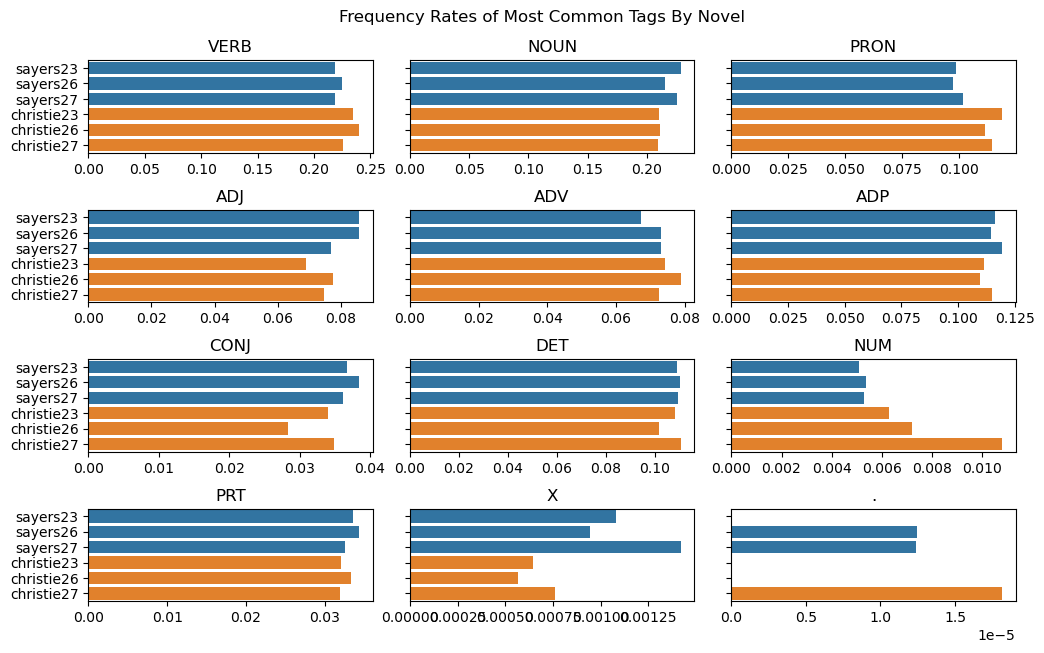

In [24]:
nrows = 4
ncols = 3
tags = tag_freqs.columns[:-1].to_numpy().reshape((nrows,ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey = True, figsize=(10,6))
fig.tight_layout(h_pad=2)
for row in range(nrows):
    for col in range(ncols):
        ax = axes[row][col]
        tag = tags[row][col]
        ax.set_title(tag)
        sns.barplot(
            data = tag_freqs[[tag, 'author']].reset_index(),
            x = tag,
            y = 'index',
            hue = 'author',
            legend = False,
            ax = ax
        )
        ax.set_ylabel('')
        ax.set_xlabel('')
fig.suptitle('Frequency Rates of Most Common Tags By Novel', y = 1.05);

As with type frequency, examining the table and barplots reveals differences between authors in terms of part-of-speech frequency. These differences become clearer if we compare overall frequency rates between Sayers's novels taken as a whole and Christie's novels taken as a whole.

In [25]:
sayers_tag_freq = Counter(
    np.concatenate(corpus[corpus['author'] == 'Sayers']['tags'].to_numpy())
)
christie_tag_freq = Counter(
    np.concatenate(corpus[corpus['author'] == 'Christie']['tags'].to_numpy())
)

tag_freqs_total = pd.DataFrame(
    index=['Sayers', 'Christie'],
    columns=tagset, 
    data = [
        [ freqdist[t]/length for t in tagset ] 
        for freqdist, length in zip([
            sayers_tag_freq, christie_tag_freq],
            [sayers_len, christie_len]
        )
    ])
tag_freqs_total

,VERB,NOUN,PRON,ADJ,ADV,ADP,CONJ,DET,NUM,PRT,X,.
Sayers,0.220731,0.222258,0.099362,0.082596,0.071561,0.116712,0.037146,0.109709,0.005250,0.033509,0.001155,0.000009
Christie,0.233953,0.210350,0.114841,0.073916,0.075428,0.111791,0.032203,0.106394,0.007929,0.032541,0.000650,0.000005


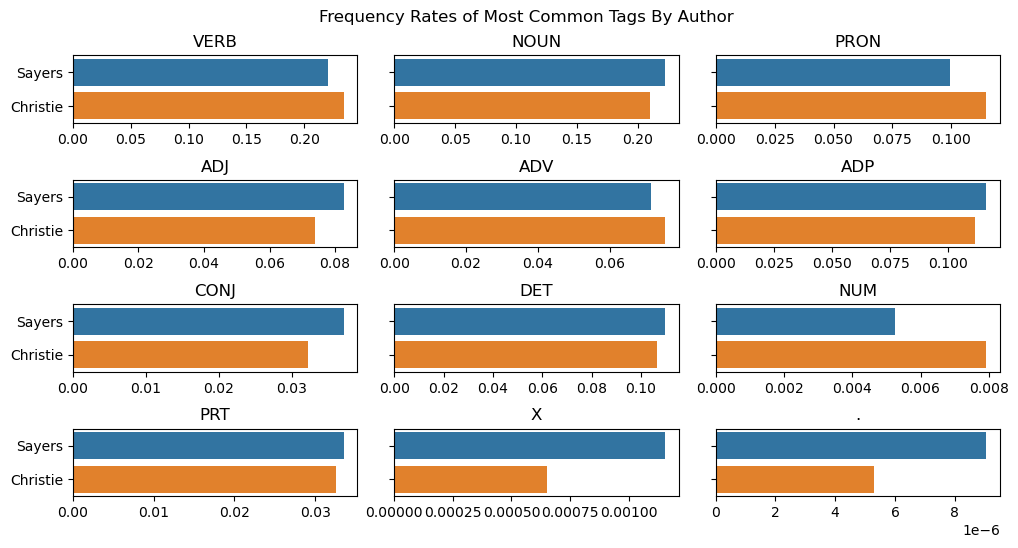

In [26]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey = True, figsize=(10,5))
fig.tight_layout(h_pad=2)
for row in range(nrows):
    for col in range(ncols):
        ax = axes[row][col]
        tag = tags[row][col]
        ax.set_title(tag)
        sns.barplot(
            data = tag_freqs_total[tag].reset_index(),
            x = tag,
            y = 'index',
            hue = 'index',
            legend = False,
            ax = ax
        )
        ax.set_ylabel('')
        ax.set_xlabel('')
fig.suptitle('Frequency Rates of Most Common Tags By Author', y = 1.05);

Some of the most drastic differences between authors occur with the tags `.` and `X`, which represent punctuation marks and uncategorized types, respectively. These parts-of-speech categories occur very seldom and may not be easily interpretable indicators of stylistic differences. So we will set these two tags aside and focus on the others.

Looking at the other tags, we can observe intriguing differences in how often the two authors use different parts of speech. In general, for example, Sayers uses more nouns  and adjectives than Christie does, while Christie uses more verbs and adverbs than Sayers does. This suggests that Sayers's writing is more descriptive while Christie's is more active, at least in terms of the parts of speech they use.

Notably, some of these differences in part-of-speech rates neatly match the differences in type rates seen in the previous section. Earlier, we noted that the type "and" occurs more often in Sayers' novels than in Christie's. According to our part-of-speech analysis, this is actually part of a larger trend of Sayers employing conjunctions more often than Christie does. Similarly, our earlier discovery that Christie uses the types "I" and "you" at a higher rate than Sayers matches the current evidence that Christie tends to use pronouns more frequently than Sayers does.

To conclude our analysis of differences in style reflected in parts of speech, we will turn to `CountVectorizer` again, this time using the part-of-speech tags as features.

In [27]:
joined_tags = corpus['tags'].str.join(' ')

vec = CountVectorizer(input='content')
X = vec.fit_transform(joined_tags).toarray()
vec.get_feature_names_out()

array(['adj', 'adp', 'adv', 'conj', 'det', 'noun', 'num', 'pron', 'prt',
       'verb'], dtype=object)

(Note that `CountVectorizer` has chosen to exclude the `.` and `X` tags from the feature set, validating our earlier decision to ignore these tags.)

Each of the six vectors in `X` now represents the part-of-speech counts for the corresponding novel. For example, the vector for *Whose Body?* looks like this:

In [28]:
X[0]

array([ 5095,  6895,  3987,  2176,  6472, 13537,   302,  5845,  1992,
       12937])

Once again, we will use PCA to project these vectors down into 2 dimensions for easier analysis.

In [29]:
projected = pd.DataFrame(
    data = PCA(n_components=2).fit_transform(X),
    columns = ['x', 'y']
)
projected['label'] = corpus['abbrev']
projected['author'] = corpus['author']
projected

,x,y,label,author
0,3345.679746,1355.029160,sayers23,Sayers
1,-4554.531186,276.189565,sayers26,Sayers
2,-4931.889931,580.299589,sayers27,Sayers
3,1763.535362,-944.191235,christie23,Christie
4,-913.909500,-1282.361095,christie26,Christie
5,5291.115510,15.034016,christie27,Christie


When we fit a linear SVC to these vectors and plot the resultant decision boundary and margins, we see that the vectors for the novels are clearly linearly separable based on frequencies of parts of speech.

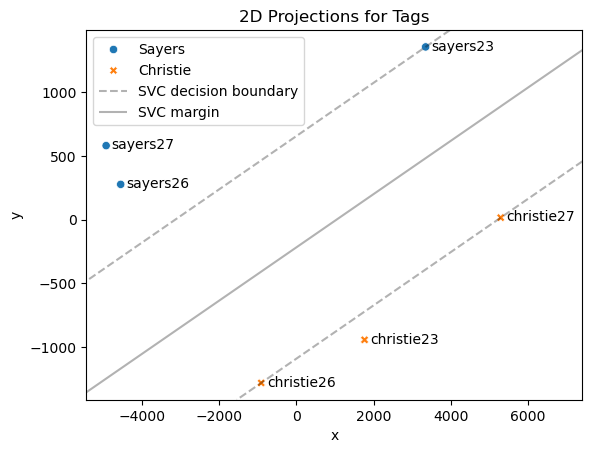

In [30]:
plot_projections(
    data = projected,
    title = '2D Projections for Tags',
    legend_loc = 'upper left'
)

This confirms our observation that the relative frequencies of parts of speech in Sayers's and Christie's novels are related to their unique writing styles. Interestingly, the part-of-speech frequency vectors for each author are clustered together more closely than the type frequency vectors were. This suggests that differences in part-of-speech usage may be more significant markers of consistent stylistic differences between the authors than differences in type usage are.

# Conclusion

As the preceding sections demonstrate, frequency rates of both types and parts of speech serve as viable indicators of stylistic differences between the six novels of Dorothy L. Sayers and Agatha Christie that were included in our corpus. Since these books are all mystery novels belonging to the same time period and country of origin, the observed differences are likely due to the authors' unique stylomes rather than confounding factors such as genre, time, and place.

Part-of-speech usage may reflect more consistent differences in stylomes than type usage does, though both linearly separate the novels from one another. Further research is needed to investigate the significance of these differences and answer the questions raised by this study, such as whether the higher frequency of nouns and adjectives in Sayers' novels reflects a more descriptive writing style.

Given the small number of samples in the corpus, this project's conclusions about stylistic differences should be interpreted with caution, especially since they may not necessarily apply to the rest of the authors' oeuvres. Once more novels by Sayers and Christie enter the public domain, it would be worthwhile to repeat this stylometric analysis on a larger corpus to see if the findings from the smaller corpus still hold.